# Dimensionality reduction

In this notebook, I explore the application of three dimensionality reduction techniques—Principal Component Analysis (PCA), Non-negative Matrix Factorization (NMF), and Uniform Manifold Approximation and Projection (UMAP)—to the Fashion MNIST dataset. The goal is to reduce the number of features needed to describe the dataset while preserving the essential information for downstream tasks such as clustering and classification.

Before applying these methods, I **normalize** the data by dividing all pixel values by 255, the maximum pixel intensity. Normalization ensures that all features contribute equally to the analysis and prevents variables with larger scales from dominating the results.


### PCA (Principal Component Analysis)

PCA is a linear dimensionality reduction technique that seeks to maximize the variance explained by the principal components. It is particularly useful for tasks where the goal is to reduce the dimensionality of the data while retaining as much variance as possible.

**Component Selection**: From the PCA analysis, I observe that the majority of the explained variance is contained within the first few principal components. The "elbow" of the explained variance curve occurs around the 70% mark, indicating that selecting components up to this point can capture a substantial portion of the dataset's variability. By using 10, 20, and 80 components, I create reduced datasets that explain approximately 70%, 80%, and 90% of the variance, respectively.

**Interpretability**: The first few principal components capture distinct patterns in the dataset:
- The first differentiates between shirts and shoes.
- The second distinguishes trousers from bags.
- The third differentiates shirts from ankle boots.
- The fourth distinguishes shoes from coats. 

As the number of components increases, the interpretability of the components decreases, with later components becoming more abstract and harder to attribute to specific clothing items.

**Reconstruction**: Reconstruction using the first 10 principal components achieves good results for shirts, shoes, and some bags, though some categories (such as sandals) are reconstructed as shoes. As the number of components increases, the reconstructions improve, particularly for more complex items like bags and sandals. With 80 components, the reconstructions are more faithful across all clothing types, though some blurriness persists for certain items.

### NMF (Non-negative Matrix Factorization)

NMF is a matrix factorization technique that decomposes the data into two non-negative matrices, providing a parts-based representation. Although NMF does not directly measure explained variance, I calculate a proxy using the reconstruction error (Frobenius norm) to assess the quality of the decomposition.

**Component Selection**: NMF achieves 87%, 90%, and 95% explained variance with 10, 20, and 80 components, respectively. Although the variance explained is slightly lower than that of PCA, NMF provides highly interpretable components that capture distinct clothing features. For example, the decomposition reveals patterns that align with shapes of various clothing items such as dresses, sneakers, and shirts.
    
**Interpretability**: NMF components are highly interpretable, especially with 10 components, which reveal clear patterns like shirt sleeves, shoe soles, and dress shapes. With 20 components, the decomposition still preserves recognizable clothing patterns, though it begins to focus more on specific parts of items, such as the center of a shirt or the sole of a shoe. With 80 components, the decomposition becomes harder to interpret, as multiple components focus on similar features, and the overall segmentation becomes more granular.
    
**Reconstruction**: Reconstruction with NMF faces challenges in reproducing items like coats, sandals, and bags with fewer components (10 or 20), though with 80 components, reconstructions are much improved, albeit slightly blurry. The method faces similar reconstruction issues to PCA, with sandals and bags being particularly difficult to reconstruct.

### UMAP (Uniform Manifold Approximation and Projection)

UMAP is a non-linear dimensionality reduction technique that preserves local structure and topological relationships, making it particularly useful for visualization and understanding complex relationships in high-dimensional data. Unlike PCA and NMF, UMAP doesn’t focus on maximizing variance but rather on preserving the local geometry of the data.

**Component Selection**: Since UMAP does not provide a direct variance explanation, I use the same values of n_components (10, 20, and 80) as in PCA and NMF for consistency. This allows for a fair comparison across methods, though the interpretation of the components in UMAP differs significantly from the linear methods.

**Interpretability and Reconstruction**: Reconstructing the original data from UMAP's reduced representations can be challenging, especially in higher dimensions (e.g., 10, 20, or 80 components). UMAP's non-linear approach prioritizes preserving the local geometry of the data over enabling reconstruction, making inverse transformations less straightforward compared to linear methods like PCA or NMF.

For lower-dimensional embeddings (e.g., 2D), inverse transformation and reconstruction work better but still pose limitations. To analyze the structure of the reduced space, I performed a reconstruction analysis using a grid of 100 points in the 2D space. While the reconstructions are computationally expensive, they provide valuable insights into the structure of the reduced space, showing how UMAP attempts to recreate the original images from its lower-dimensional embedding.

UMAP's embeddings are particularly useful for visualizing the data in lower dimensions. The resulting reveal distinct clusters that correspond to different clothing types:
- The top-left cluster represents sneakers, ankle boots, and sandals.
- The top-right cluster represents pants.
- The bottom-left cluster represents bags.
- The bottom-middle cluster corresponds to coats and pullovers.
- The bottom-right cluster represents dresses and t-shirts. These groupings demonstrate UMAP’s ability to capture the local structure of the data, preserving the relationships between similar clothing items.

UMAP's strengths lie in visualizing complex data distributions and identifying patterns, rather than in reconstructing the original data accurately.

In [1]:
from kagglehub import dataset_download
from pathlib import Path
import pandas as pd 
import pickle

from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA, NMF, MiniBatchNMF
import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
import umap.plot

/home/martin/Bureau/IBM Machine Learning Specialisation/fashion-mnist-clusturing/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/martin/Bureau/IBM Machine Learning Specialisation/fashion-mnist-clusturing/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/martin/Bureau/IBM Machine Learning Specialisation/fashion-mnist-clusturing/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument typ

In [2]:
FASHION_MNIST_HANDLE = 'zalando-research/fashionmnist'

data_location = dataset_download(FASHION_MNIST_HANDLE)
# data_location = '~/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4'

kaggle_data_forlder = Path(data_location)
train_data_filename = 'fashion-mnist_train.csv'

df = pd.read_csv(kaggle_data_forlder / train_data_filename)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train, y_train = df.drop(columns='label'), df['label']

custom_normalizer = FunctionTransformer(func=(lambda x: x / 255), inverse_func=(lambda x: (x*255).astype(int)))

X_scaled = custom_normalizer.fit_transform(X_train)
X_scaled.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### Useful Decorators

In [4]:
def pickle_load_if_exists(path:Path = None): 
    def decorator(function): 
        def wrapper(*args, **kwargs):
            if path.exists(): 
                buff = path.open('rb')
                res = pickle.load(buff) 
            else:
                res = function(*args, **kwargs)
                path.parent.mkdir(parents=True, exist_ok=True)
                buff = path.open('wb')
                pickle.dump(res, buff)
            buff.close()
            return res
        return wrapper
    return decorator

In [5]:
def pandas_load_if_exists(path: Path): 
    def decorator(function): 
        def wrapper(*args, **kwargs):
            if path.exists(): 
                res = pd.read_csv(path) 
            else:
                res = function(*args, **kwargs)
                path.parent.mkdir(parents=True, exist_ok=True)
                res.to_csv(path, index=False)
            return res
        return wrapper
    return decorator

## Principal Componant Analysis (PCA)

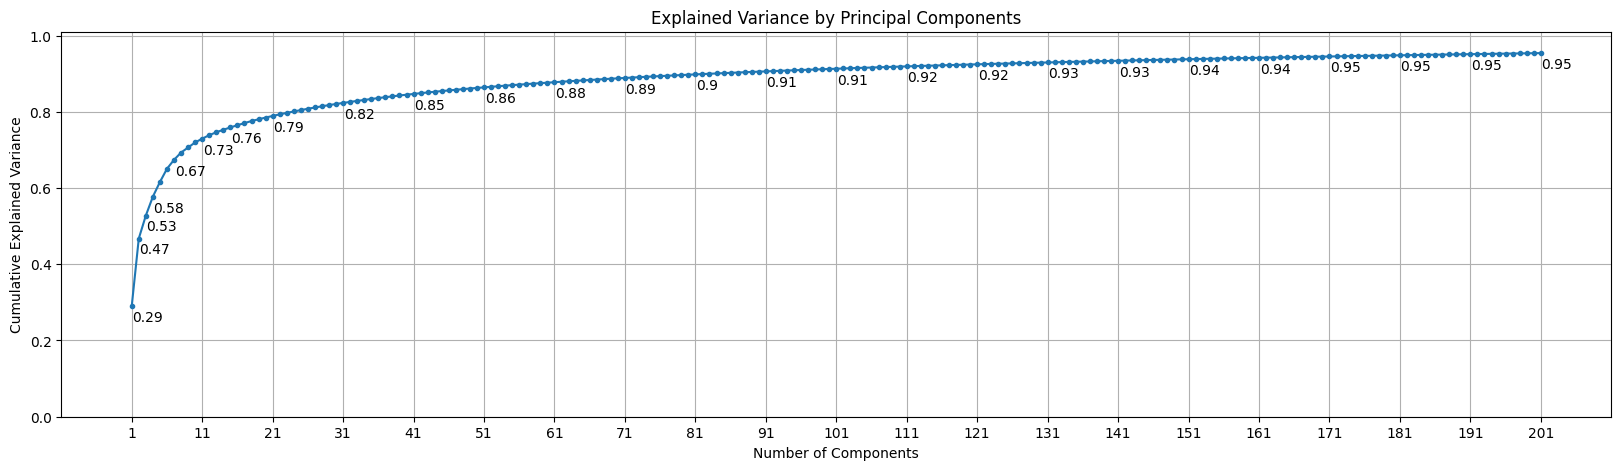

In [6]:
n_components = 201 
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
pca_cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(20, 5))
plt.plot(pca_cumulative_explained_variance_ratio, marker='.')

x_ticks = range(0, n_components, 10)

padding_x = 0.1
padding_y = - 0.04

for i in x_ticks: 
    plt.text(
        x=i + padding_x, y=pca_cumulative_explained_variance_ratio[i] + padding_y,               
        s=round(pca_cumulative_explained_variance_ratio[i], 2)
    )

for i in [1, 2, 3, 6, 14]: 
    plt.text(
        x=i + padding_x, y=pca_cumulative_explained_variance_ratio[i] + padding_y,               
        s=round(pca_cumulative_explained_variance_ratio[i], 2)
    )

plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim([0, 1.01])
plt.xticks( x_ticks, labels=[x + 1 for x in x_ticks] )
plt.grid()
plt.show()


Observations: 
- Most of the explain variance is contained in the first principal components as it is expected.
- There is a smoth "elbow" so its hard to make a decision but analysing the curve we can make some interesting cuts.
- The corner of the elbow is achieved around 70% of variance explained.
- After the 20th component, we achieved 80% of variance explained.
- To achieve 90% of variance explained, we need to wait until the 80th component.
- From the 90th component, each time we want to get one aditionnal percent of variance explained, we need to add 20 components, until the 170th component 
- From the 170th to the 200th component we gain no additional information

From these observations, we can form 3 reduced datasets with 10, 20 and 80 components containing approximatly 70%, 80%, and 90% of the explained variance.

In [7]:
columns = [f'PC_{i}' for i in range(80)]
X_pca_10 = pd.DataFrame(X_pca[:, :10], columns=columns[:10])
X_pca_20 = pd.DataFrame(X_pca[:, :20], columns=columns[:20])
X_pca_80 = pd.DataFrame(X_pca[:, :80], columns=columns[:80])

In [8]:
X_pca_10.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
0,3.686333,4.960529,-0.051232,-2.733349,0.391787,1.149178,0.875894,-2.567449,-1.114391,0.786255
1,-4.376434,3.861059,-1.949433,-0.803178,0.451490,-0.779967,-1.230174,-1.014531,1.412427,-0.985630
2,7.265152,1.568757,2.315239,0.222004,1.048076,-1.161953,-1.070445,0.301790,-0.431266,-0.090305
3,3.227788,-2.325256,-0.649302,1.201164,-0.273992,3.971531,-0.525023,0.135215,-0.050613,-0.620054
4,4.146373,-4.039080,-1.515247,-1.861385,0.561363,0.067154,-0.696509,0.157455,-2.034535,-0.336144


In [9]:
model_selection_dir = Path('model_selection')
data_dir = model_selection_dir / 'data'
models_dir = model_selection_dir / 'models'

if not data_dir.exists(): 
    data_dir.mkdir(parents=True, exist_ok=True)

if not models_dir.exists(): 
    models_dir.mkdir(parents=True, exist_ok=True)

X_pca_10.to_csv(data_dir / 'X_pca_10.csv', index=False)
X_pca_20.to_csv(data_dir / 'X_pca_20.csv', index=False)
X_pca_80.to_csv(data_dir / 'X_pca_80.csv', index=False)

with open(models_dir / 'pca.pkl', 'wb') as f:
    pickle.dump(pca, f)


In [10]:
def show_28x28_images(X, n_cols=5, n_rows=5, figsize=(12, 12), title=None, cmap='binary'): 
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=figsize)
    for i in range(n_rows):
        for j in range(n_cols): 
            idx = (i*n_cols)+j

            axs[i][j].imshow( X[idx].reshape((28, 28)) , cmap )
            axs[i][j].set_axis_off()

    if title is not None: 
        fig.suptitle(title)
    fig.tight_layout()
    plt.show()

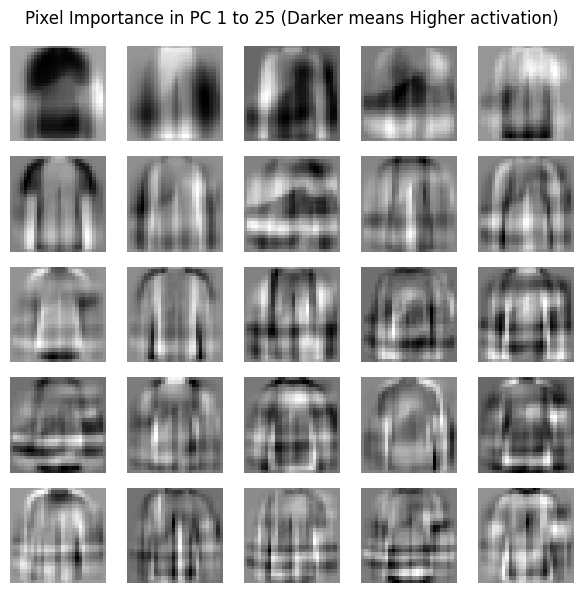

In [11]:
ones = np.ones((1, 784))

components_images = np.zeros((25, 784))

for i in range(0, 25): 

    component = pca.components_[[i]]

    pca_projected = ones.dot(component.T)
    components_images[i] = custom_normalizer.inverse_transform(
        np.dot(pca_projected, component)
    )

show_28x28_images(components_images, n_cols=5, n_rows=5, figsize=(6,6), title='Pixel Importance in PC 1 to 25 (Darker means Higher activation)')

Observations: 
- The first componant seems to be able to classify well between shirts and shoes
- The second componant seems to be able to classify well between trousers and bags
- The third componant seems to be able to classify well between shirts and ankle boots
- The fourth componant seems to be able to classify well between shoues and coats 
- The following componants are less easy to interpret and tend to be less and less human readables (with does not means they dont hold valuable informations)

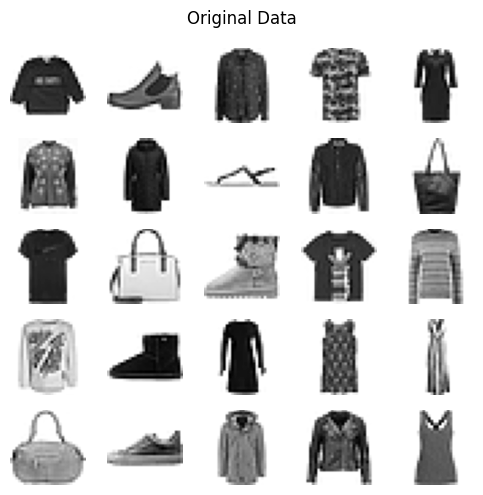

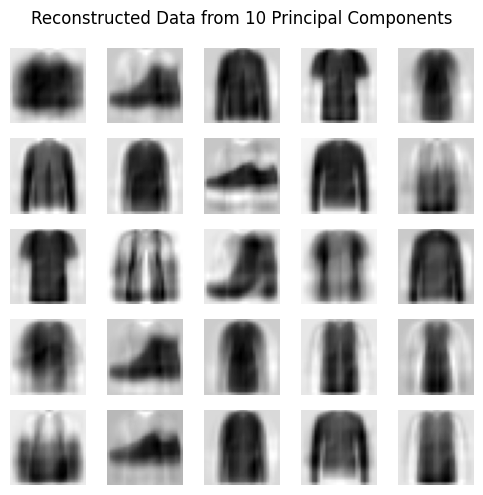

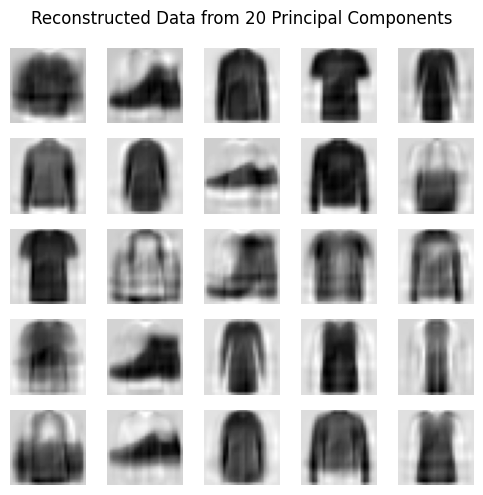

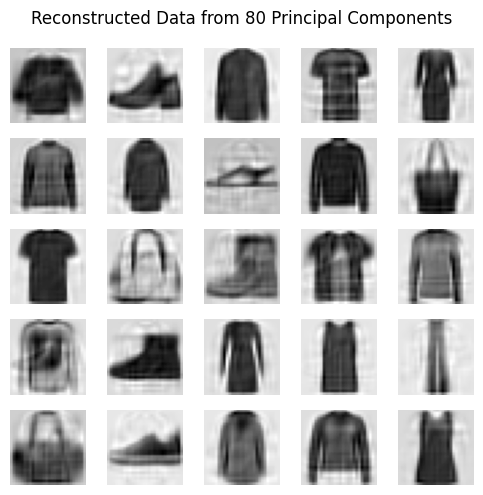

In [12]:
fig = show_28x28_images(X_train.values[0:25], figsize=(5,5), title='Original Data')
for i in [10, 20, 80]: 
    components = pca.components_[:i]
    X_pca_projected = X_scaled[0:25].dot(components.T)
    X_reconstructed = custom_normalizer.inverse_transform(
        np.dot(X_pca_projected, components)
    )
    show_28x28_images(X_reconstructed, figsize=(5,5), title=f'Reconstructed Data from {i} Principal Components')


Observations: 
- Projections on 10 Principal Componants seems to achieve to reconstruct well shirts and shoes, maybe dresses and some bags. A sandal is reconstructed as a shoe 
- Projections on 20 Principal Componants seems to achieve to reconstruct better shirts ands shoes, dresses and bags. A sandal is still reconstructed as a shoe
- Projections on 80 Principal Componants seems better reconstruction of everything, we can the a sandal being well reconstructed a it is. Bags are way more faithful than previous projections 

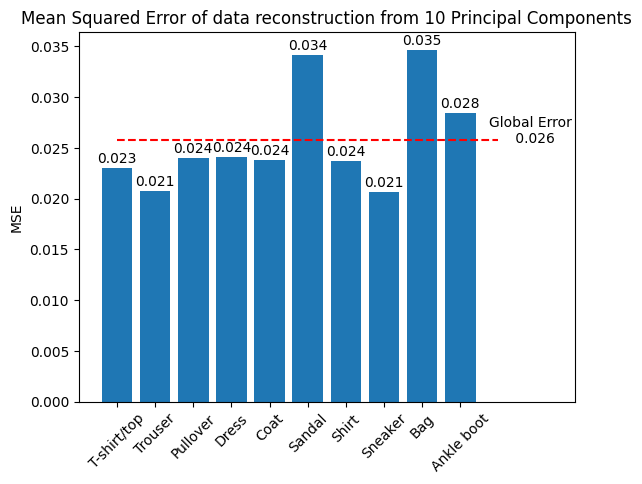

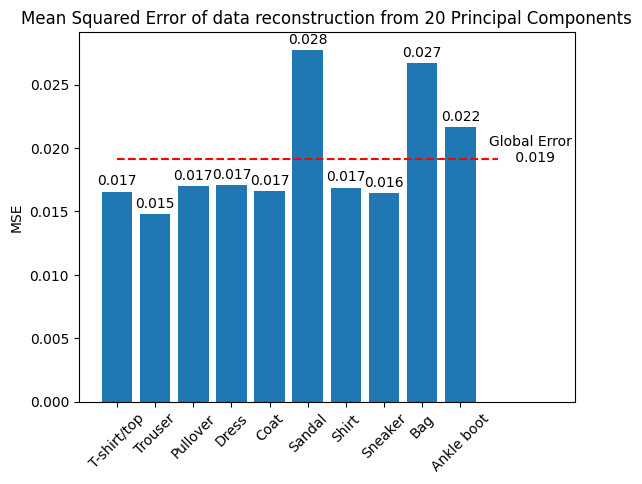

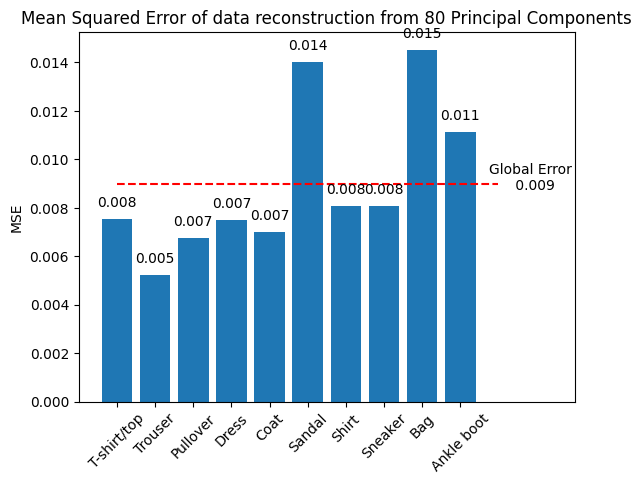

In [13]:
labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
padding_y = 0.0005

for i in [10, 20, 80]: 
    components = pca.components_[:i]
    X_pca_projected = X_scaled.dot(components.T)
    X_reconstructed = np.dot(X_pca_projected, components)

    global_error = np.mean((X_scaled - X_reconstructed) ** 2)

    reconstruction_errors = []

    for id in range(len(labels)): 
        error = np.mean((X_scaled - X_reconstructed)[y_train == id] ** 2)
        reconstruction_errors.append(error)

        plt.text(id, error + padding_y, str(round(error, 3)), ha='center', fontsize=10)

    plt.bar(x=labels, height=reconstruction_errors)

    plt.hlines(y=global_error, xmax=len(labels), xmin=0, linestyles='dashed', color='red')
    plt.text(
        x=10.9, y=global_error-padding_y/2, s=f'Global Error \n {round(global_error, 3)}', ha='center', fontsize=10
    )
    plt.xlim([-1, 12])
    plt.xticks( rotation=45 )

    plt.ylabel('MSE')
    plt.title(f'Mean Squared Error of data reconstruction from {i} Principal Components')
    plt.show()

Observations: 
- With the number of components there is improvement everywhere but some clothes type have better improvement thant the others.
- Going from 10 to 20 components, there is an improvement on the reconstruction of shirts and bags.
- Going from 20 to 80 components, there is an improvement on the reconstruction of sandals and a slight improvements on Pullovers.

## Non-negative Matrix Factorization (NMF)

Although NMF doesn’t provide a direct measure of explained variance, you can compute the ratio of the reconstruction norm to the original norm as a proxy:

$\text{Explained Variance Proxy} = 1 - \frac{||X - WH||_{Fro}^{2}}{||X||_{Fro}^{2}}$

With: 
- ${||X - WH||_{Fro}}$ the reconstruction error, the Frobenius norm of the difference between the original dataset and its reconstruction
- $||X||_{Fro}^{2}$ the total variance of the dataset, the squared Frobenius norm of the original dataset

It is an adaptation inspired by the concept of variance explained in PCA, adjusted for NMF. Since NMF minimizes the Frobenius norm of the reconstruction error, this formula provides a way to measure the quality of the reconstruction as a fraction of the original dataset information level.

Alternative names: 
- Reconstruction quality metric 
- proportion of reconstruction accuracy


In [14]:
def explained_variance_proxy(X, nmf_model):  
    total_variance = np.linalg.norm(X, 'fro') ** 2
    explained_variance = 1 - (nmf_model.reconstruction_err_ ** 2  / total_variance)

    return explained_variance

In [15]:
%%time
nmf = NMF(n_components=20, max_iter=500, random_state=42, beta_loss='frobenius')
nmf.fit(X_scaled)
print(explained_variance_proxy(X_scaled, nmf))

0.8976207882857572
CPU times: user 19min 25s, sys: 5.29 s, total: 19min 31s
Wall time: 3min


In [16]:
%%time
batched_nmf = MiniBatchNMF(n_components=20, max_iter=500, random_state=42, beta_loss='frobenius')
batched_nmf.fit(X_scaled)
print(explained_variance_proxy(X_scaled, batched_nmf))

0.8585858095714622
CPU times: user 9min 11s, sys: 2.53 s, total: 9min 13s
Wall time: 1min 21s


On my machine NMF decomposition in 20 components takes more than twice the time to run compared to MiniBatchNMF with the same settings.

The explained variance with NMF is greater than the explained variance with MiniBatchNMF.  

In [17]:
@pickle_load_if_exists(path=Path('model_selection/models/NMF_models.pkl'))
def compute_NMF_models(X, n_components_values): 
    NMF_models = []

    for i, n_components in enumerate(n_components_values): 
        NMF_models.append(NMF(n_components=n_components, max_iter=500, random_state=42, beta_loss='frobenius'))
        NMF_models[i].fit(X)

    return NMF_models

In [18]:
@pickle_load_if_exists(path=Path('model_selection/models/MiniBatchNMF_models.pkl'))
def compute_MiniBatchNMF_models(X, n_components_values): 
    miniBatchNMF_models = []

    for i, n_components in enumerate(n_components_values): 
        miniBatchNMF_models.append(MiniBatchNMF(n_components=n_components, max_iter=500, random_state=42, beta_loss='frobenius'))
        miniBatchNMF_models[i].fit(X)

    return miniBatchNMF_models

In [19]:
n_components_values = [ 2, 3, 5, 7, 10, 15, 20, 30, 50, 80 ]
NMF_models = compute_NMF_models(X_scaled, n_components_values)

In [20]:
miniBatchNMF_models = compute_MiniBatchNMF_models(X_scaled, n_components_values)

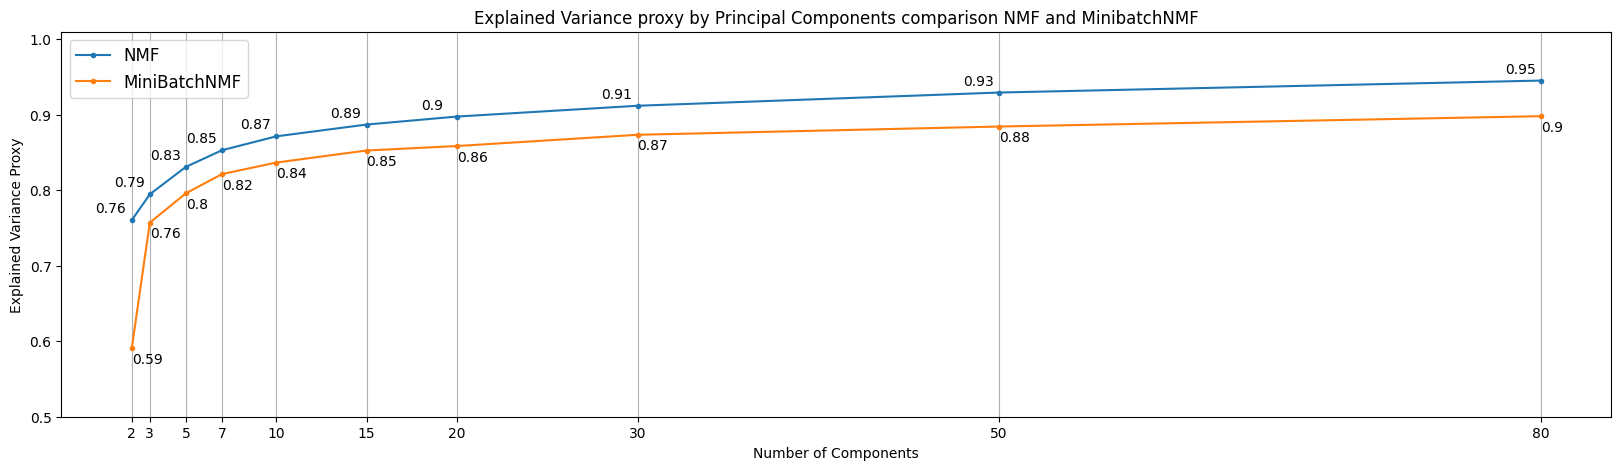

In [21]:
plt.figure(figsize=(20, 5))

nmf_x_padding = -2
nmf_y_padding = 0.01

miniBatch_nmf_x_padding = 0 
miniBatch_nmf_y_padding = - 0.02

nmf_explained_variances = [explained_variance_proxy(X_scaled, nmf) for nmf in NMF_models]
miniBatch_nmf_explained_variances = [explained_variance_proxy(X_scaled, nmf) for nmf in miniBatchNMF_models]

plt.plot(n_components_values, nmf_explained_variances, marker='.', label='NMF')
plt.plot(n_components_values, miniBatch_nmf_explained_variances, marker='.', label='MiniBatchNMF')

for i, n_components in enumerate(n_components_values): 
    plt.text(
        x=n_components + nmf_x_padding, y=nmf_explained_variances[i] + nmf_y_padding,               
        s=round(nmf_explained_variances[i], 2)
    )
    plt.text(
        x=n_components + miniBatch_nmf_x_padding, y=miniBatch_nmf_explained_variances[i] + miniBatch_nmf_y_padding,               
        s=round(miniBatch_nmf_explained_variances[i], 2)
    )    

plt.ylim([0.5, 1.01])
plt.grid(axis='x', which='major')
plt.xticks(n_components_values)
plt.legend(fontsize='large')

plt.title('Explained Variance proxy by Principal Components comparison NMF and MinibatchNMF')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Proxy')

plt.show()


Observations: 
- The explained variance from MinibatchNMF is always under NMF for a given number of components, however they follow the same growing trend making MinibatchNMF a very good tool to decide with what number of components we should use to train NMF models  
- We could tune MinibatchNMF to get better result but the time needed too tune it is too important, it is more worth to use normal NMF given the dataset size (60k samples).
- With default settings, to get 88% of variance explained with default settings MinibatchNMF it have to use 50 components, while with NMF only we achieve 87% with only 10 components

From these observations, we can form 3 reduced datasets with 10, 20 and 80 components containing approximatly 87%, 90%, and 95% of the explained variance.


In [22]:
def nmf_transform(X, nmf_model, column_names=None): 
    @pandas_load_if_exists(path=Path(f'model_selection/data/X_nmf_{nmf_model.n_components}.csv'))
    def get_transform_data(X, nmf_model, column_names):      
        X_nmf = pd.DataFrame(nmf_model.transform(X), columns=column_names)
        return X_nmf
    return get_transform_data(X, nmf_model, column_names) 

In [23]:
nmf_10, nmf_20, nmf_80 = [ model for model in NMF_models if model.n_components in (10, 20, 80) ] 
components_column_names = [f'Component_{i}' for i in range(80)]

X_nmf_10 = nmf_transform(X_scaled, nmf_10, components_column_names[0: 10])
X_nmf_20 = nmf_transform(X_scaled, nmf_20, components_column_names[0: 20])
X_nmf_80 = nmf_transform(X_scaled, nmf_80, components_column_names[0: 80])

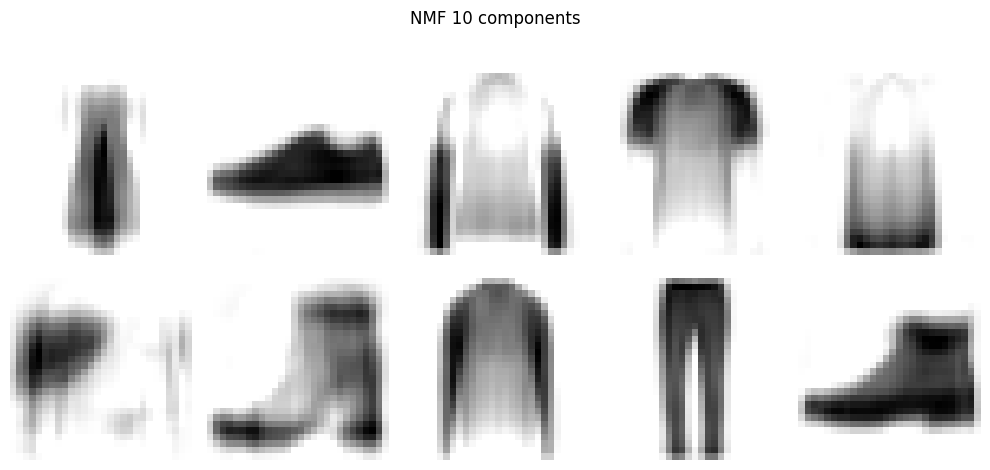

In [24]:
show_28x28_images(nmf_10.components_, n_cols=5, n_rows=2, figsize=(10, 5), title='NMF 10 components')

Observations: 
- Decomposition in 10 components achieve pretty good human redable segementation
- We can recognize shapes of clothing: dress, sneaker, shirts, tops / t-shirts, ankle boots, trouser, bag
- The 6th component is difficult to read and may be result of residual yet important information

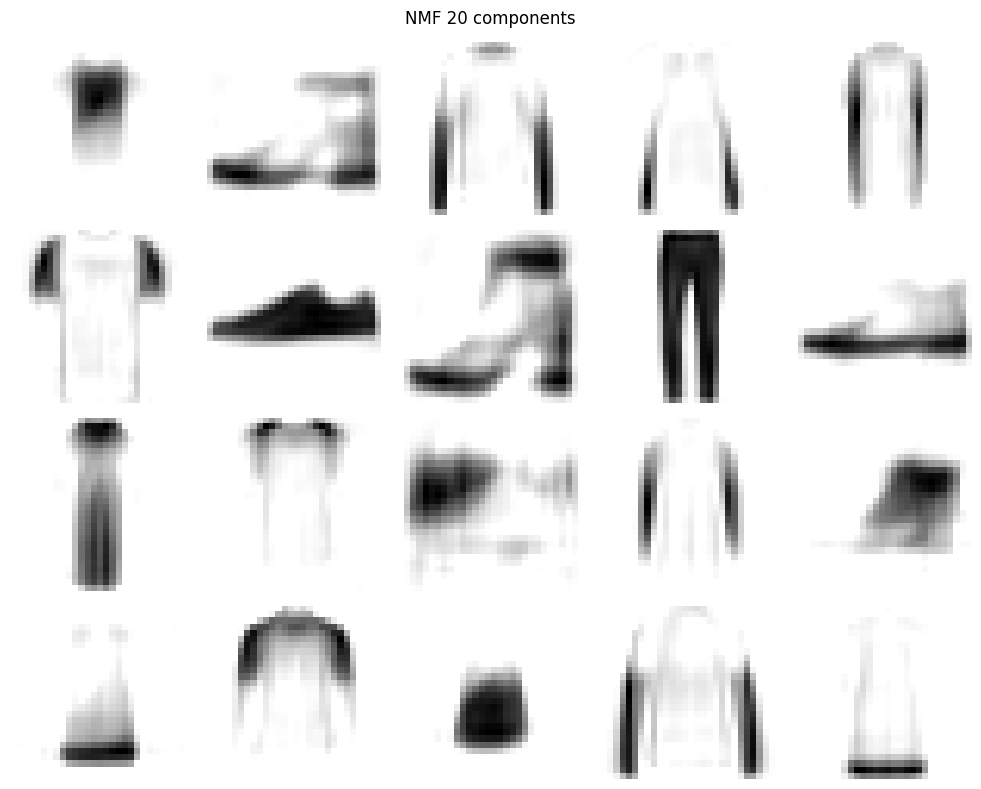

In [25]:
show_28x28_images(nmf_20.components_, n_cols=5, n_rows=4, figsize=(10, 8), title='NMF 20 components')

Observations: 
- Decomposition in 20 components still achieve pretty good human redable segementation even though the decomposition is more focused on parts of clothings more than entire cloth pieces.
- We can recognize shapes of clothing: dress, sneaker, shirts, tops / t-shirts, ankle boots, trouser but bags are not represented in one component like trousers for example.
- Some components seems complementary, for example the 3rd components represents sleeves and the first component is more focused on the center of a shirt-like cloth type. We might be able to form bags combining the 4th component with the 18th component. The 10th component is focused on the sole of a shoe.

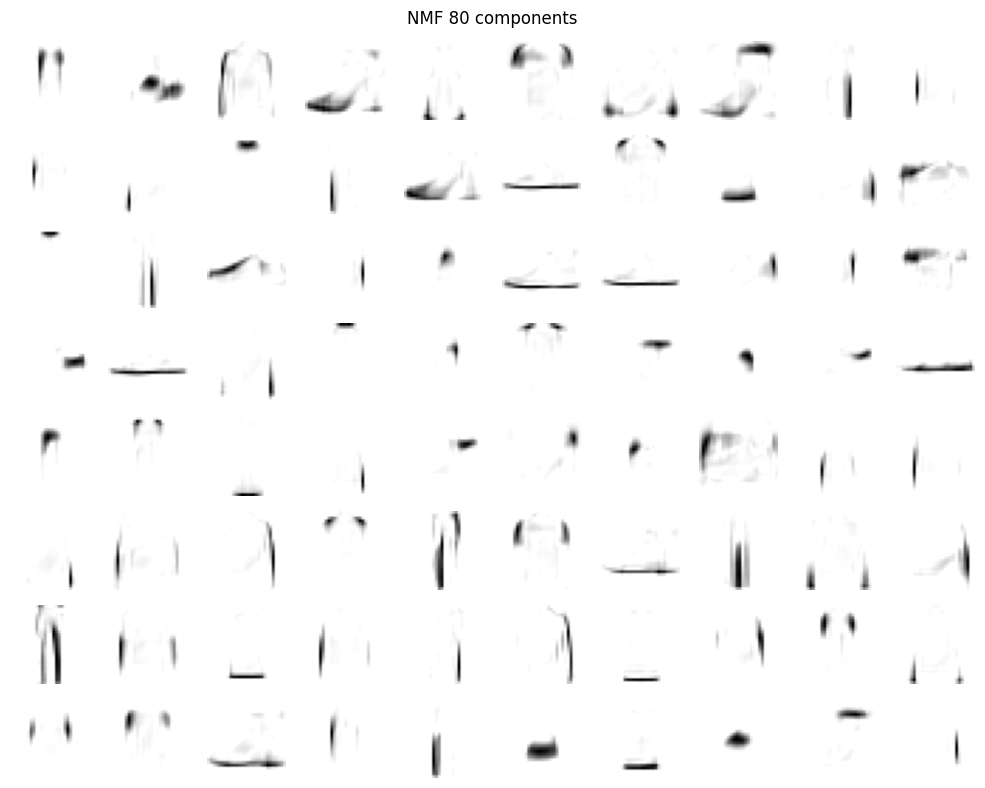

In [26]:
show_28x28_images(nmf_80.components_, n_cols=10, n_rows=8, figsize=(10, 8), title='NMF 80 components')

Observation: 
- Decomposition with 80 components achives a decomposition of clothing elements but struggle to achieve human readable decomposition
- On top of that, multiple elements tend to focus on the same thing, for example the sole of a shoe.
- It might be decomposed too much.

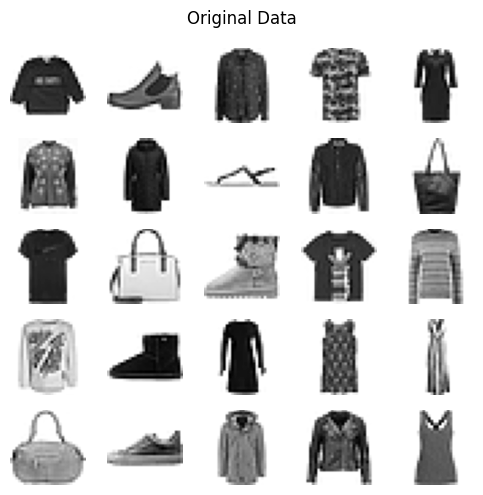

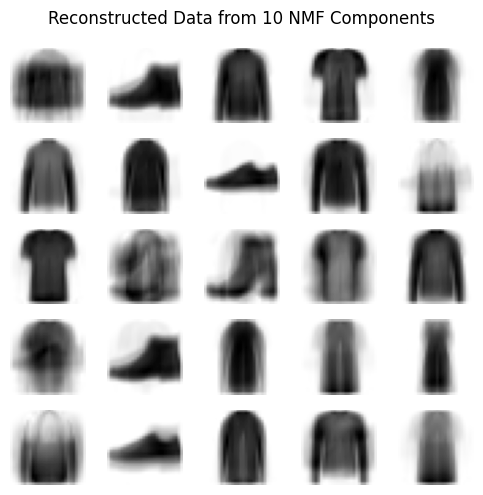

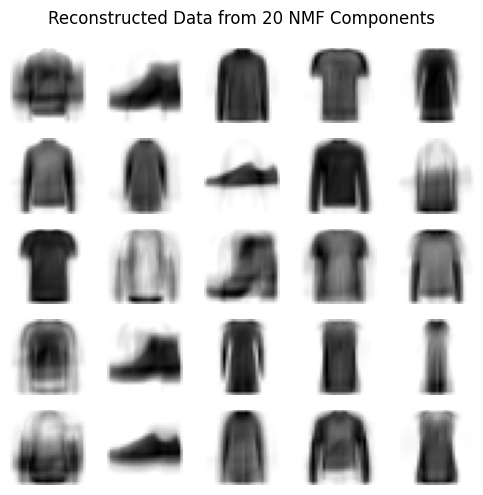

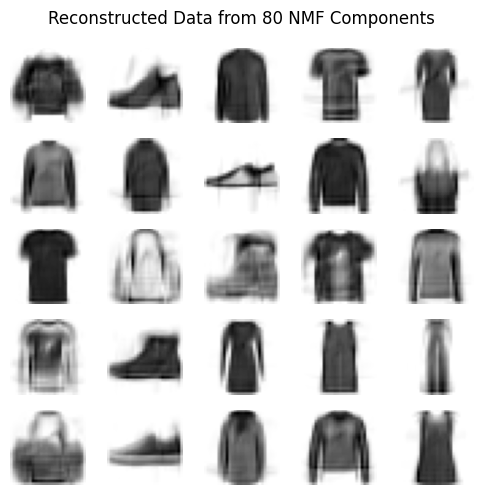

In [27]:
fig = show_28x28_images(X_scaled.values[0:25], figsize=(5,5), title='Original Data')
for nmf in [nmf_10, nmf_20, nmf_80]: 

    X_tranformed = nmf.transform(X_scaled[0:25])
    X_reconstructed = np.dot(X_tranformed, nmf.components_)

    show_28x28_images(X_reconstructed, figsize=(5,5), title=f'Reconstructed Data from {nmf.n_components_} NMF Components')


Observation: 
- It seems that coats, sandals and bags are difficult to reconstruct with 10 and 20 componants
- With 80 components, images are pretty well reconstructed but blurry 

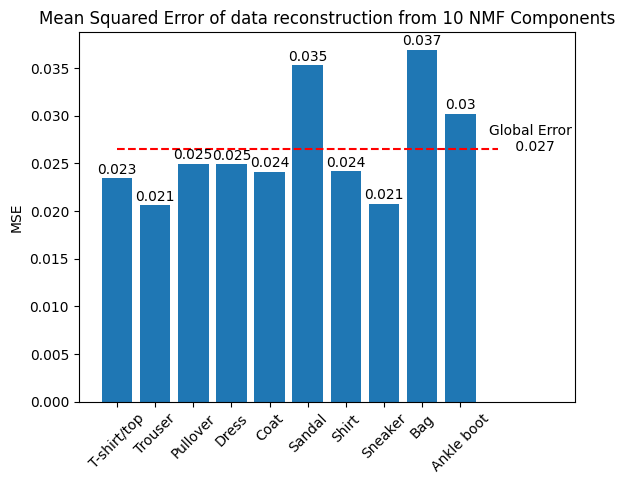

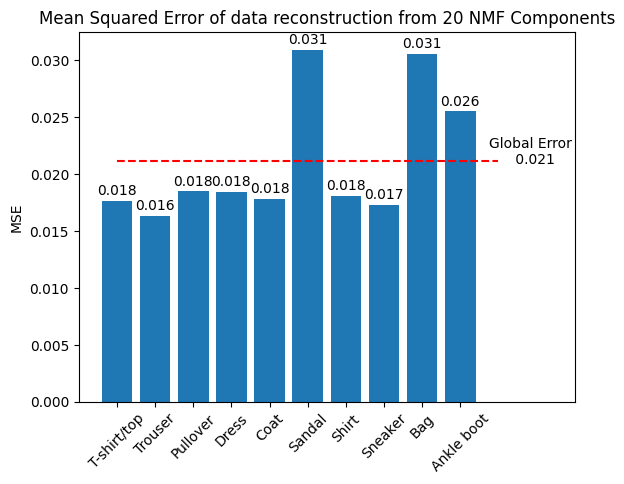

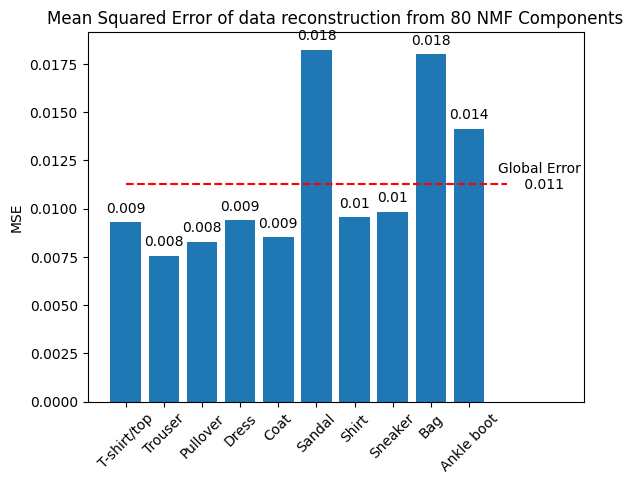

In [28]:
labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
nmf_dict = {
    10: {
        'model': nmf_10
        , 'transformed_data': X_nmf_10
    },
    20: {
        'model': nmf_20
        , 'transformed_data': X_nmf_20
    },
    80: {
        'model': nmf_80
        , 'transformed_data': X_nmf_80
    }
}
padding_y = 0.0005

for key, value in nmf_dict.items(): 
    nmf = value['model']

    X_transformed = value['transformed_data']
    X_reconstructed = np.dot(X_transformed, nmf.components_)

    global_error = np.mean((X_scaled - X_reconstructed) ** 2)

    reconstruction_errors = []

    for id in range(len(labels)): 
        error = np.mean((X_scaled - X_reconstructed)[y_train == id] ** 2)
        reconstruction_errors.append(error)

        plt.text(id, error + padding_y, str(round(error, 3)), ha='center', fontsize=10)

    plt.bar(x=labels, height=reconstruction_errors)

    plt.hlines(y=global_error, xmax=len(labels), xmin=0, linestyles='dashed', color='red')
    plt.text(
        x=10.9, y=global_error-padding_y/2, s=f'Global Error \n {round(global_error, 3)}', ha='center', fontsize=10
    )
    plt.xlim([-1, 12])
    plt.xticks( rotation=45 )

    plt.ylabel('MSE')
    plt.title(f'Mean Squared Error of data reconstruction from {key} NMF Components')
    plt.show()

Observation: 
- As with PCA, it is harder to reconstruct Sandals, Bags and Ankle boots than other clothing categories

## UMAP (Uniform Manifold Approximation and Projection)

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. 

Unlike PCA and NMF, which are linear techniques that aim to maximize variance explained by components, UMAP is a non-linear method designed to preserve local structure and topological relationships in the data. Since UMAP doesn’t rely on variance or reconstruction metrics, there is no direct way to measure the amount of variance captured by each component. Therefore, we cannot use the explained variance approach for selecting n_components in UMAP, as its optimization focuses on local relationships rather than global variance.

However, to enable a fair comparison between UMAP and the previous algorithms (PCA and NMF), I plan to use the same values of n_components (10, 20, and 80) for UMAP. This consistency in component selection across methods will allow me to directly compare their performance for downstream tasks, even though the interpretation of the components differs across these techniques. Instead of explained variance, I will rely on other evaluation metrics, such as trustworthiness, neighborhood preservation, or qualitative measures like visualization, to assess the effectiveness of UMAP at these dimensionalities.

In [29]:
def umap_fit_transform(
    n_components: int
    , X: pd.DataFrame 
) -> tuple[UMAP, pd.DataFrame]:
    
    @pickle_load_if_exists(Path(f'model_selection/models/umap_{n_components}.pkl'))
    def umap_fit(
        n_components: int
        , X: pd.DataFrame 
    ): 
        umap_reducer = UMAP(n_components=n_components, n_jobs=-1) # we use no random_state for parallelism
        umap_reducer.fit(X)
        return umap_reducer
    
    @pandas_load_if_exists(path=Path(f'model_selection/data/X_umap_{n_components}.csv'))
    def umap_transform(umap_reducer: UMAP, X: pd.DataFrame): 
        embeddings = pd.DataFrame(
            umap_reducer.transform(X)
            , columns = [f'Component_{i}' for i in range(umap_reducer.n_components)]
        )
        return embeddings
    
    umap_reducer = umap_fit(n_components, X)
    embeddings = umap_transform(umap_reducer, X)

    return umap_reducer, embeddings

In [30]:
umap_10, X_umap_10 = umap_fit_transform(n_components=10, X=X_scaled)
umap_20, X_umap_20 = umap_fit_transform(n_components=20, X=X_scaled)
umap_80, X_umap_80 = umap_fit_transform(n_components=80, X=X_scaled)

Since computing point reconstructions from UMAP's transformed space back to the original space is computationally expensive, I aimed to provide a fair sense of UMAP's accuracy, even in 2D. To achieve this, I created a grid of 100 points spanning the 2D space and calculated their reconstructions. I then compared the 2D space and the reconstructed images side by side to illustrate the results.

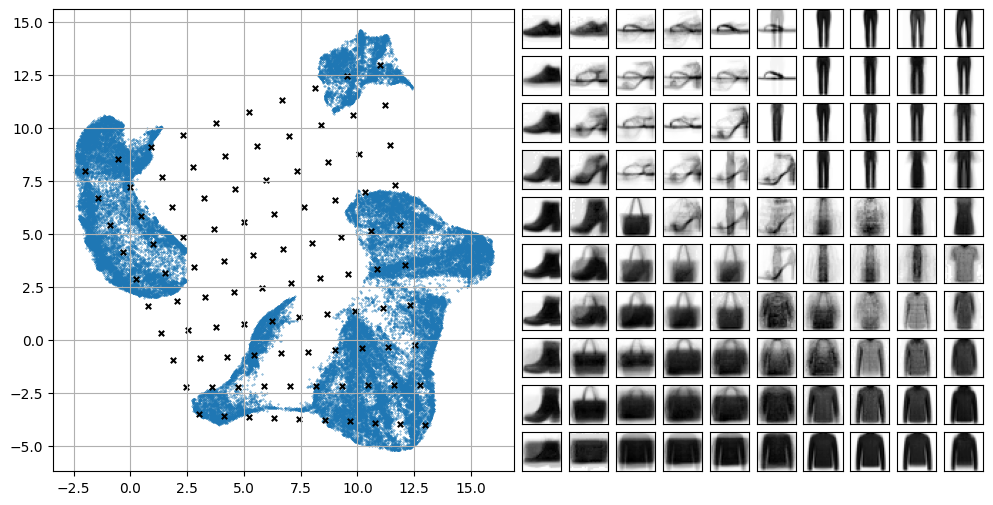

In [36]:
from matplotlib.gridspec import GridSpec

umap_2, X_umap_2 = umap_fit_transform(n_components=2, X=X_scaled)

corners = np.array([
    [-2, 8],  
    [11, 13],  
    [3, -3.5],  
    [13, -4],  
]) 

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
]) 

inv_transformed_points = umap_2.inverse_transform(test_pts)

# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)        

scatter_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    # , c=y_train.astype(np.int32)
    # , cmap='Spectral'
    , s=0.1
)

scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)
scatter_ax.grid(visible=True, which='both', axis='both')

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28), cmap='binary')
        digit_axes[i, j].set(xticks=[], yticks=[])


Since UMAP reconstructs data by mapping reduced embeddings back to the high-dimensional space using the graph structure learned during training, when a grid point appears where no actual data point exists, it tries to generate the best reconstruction based on the surrounding points.

Observations:
- The top-left blob seems to represent sneakers, ankle boots, and sandals.
- The top-right blob appears to represent pants.
- The bottom-left blob seems to correspond to bags.
- The bottom-middle blob looks like it represents coats and pullovers.
- The bottom-right blob seems to correspond to dresses and t-shirts.